## Logistic Regression



In [11]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
import pandas as pd
from joblib import load
# import time
# import os
# # class imbalance

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import make_pipeline as imb_make_pipeline
# # preprocessing
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.feature_selection import f_classif
# from sklearn.feature_selection import SelectKBest
# from sklearn.compose import ColumnTransformer
# from sklearn.model_selection import train_test_split

# # algorithms/models
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LogisticRegressionCV
# from sklearn.svm import LinearSVC, SVC
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.ensemble import RandomForestClassifier

# # model evaluation
# from imblearn.metrics import classification_report_imbalanced
# from imblearn.metrics import geometric_mean_score
# from sklearn.metrics import average_precision_score
# from sklearn.metrics import roc_auc_score


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kpdla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kpdla\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kpdla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kpdla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 3.0 MB/s eta 0:00:00


In [2]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize

In [ ]:
import pandas as pd

personality_data = pd.read_csv("/content/drive/MyDrive/NLP_PACKAGE/cleaned_data_countandvectorised.csv")

In [3]:
mbti = [
    "INFP",
    "INFJ",
    "INTP",
    "INTJ",
    "ENTP",
    "enfp",
    "ISTP",
    "ISFP",
    "ENTJ",
    "ISTJ",
    "ENFJ",
    "ISFJ",
    "ESTP",
    "ESFP",
    "ESFJ",
    "ESTJ",
]

# part of speech dictionary
tags_dict = {
    "ADJ_avg": ["JJ", "JJR", "JJS"],
    "ADP_avg": ["EX", "TO"],
    "ADV_avg": ["RB", "RBR", "RBS", "WRB"],
    "CONJ_avg": ["CC", "IN"],
    "DET_avg": ["DT", "PDT", "WDT"],
    "NOUN_avg": ["NN", "NNS", "NNP", "NNPS"],
    "NUM_avg": ["CD"],
    "PRT_avg": ["RP"],
    "PRON_avg": ["PRP", "PRP$", "WP", "WP$"],
    "VERB_avg": ["MD", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ"],
    ".": ["#", "$", "''", "(", ")", ",", ".", ":"],
    "X": ["FW", "LS", "UH"],
}

# input to the model
features = [
      "clean_posts",
        "compound_sentiment",
        "ADJ_avg",
        "ADP_avg",
        "ADV_avg",
        "CONJ_avg",
        "DET_avg",
        "NOUN_avg",
        "NUM_avg",
        "PRT_avg",
        "PRON_avg",
        "VERB_avg",
        "em",
        "word_count",
        "unique_words"
]


def unique_words(s):
    unique = set(s.split(" "))
    return len(unique)


def emojis(post):
    # does not include emojis made purely from symbols, only :word:
    emoji_count = 0
    words = post.split()
    for e in words:
        if "http" not in e:
            if e.count(":") == 2:
                emoji_count += 1
    return emoji_count


def colons(post):
    # Includes colons used in emojis
    colon_count = 0
    words = post.split()
    for e in words:
        if "http" not in e:
            colon_count += e.count(":")
    return colon_count


def lemmitize(s):
    lemmatizer = WordNetLemmatizer()
    new_s = ""
    for word in s.split(" "):
        lemmatizer.lemmatize(word)
        if word not in stopwords.words("english"):
            new_s += word + " "
    return new_s[:-1]


def clean(s):
    # remove urls
    s = re.sub(re.compile(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+).*"), "", s)
    # remove emails
    s = re.sub(re.compile(r"\S+@\S+"), "", s)
    # remove punctuation
    s = re.sub(re.compile(r"[^a-z\s]"), "", s)
    # Make everything lowercase
    s = s.lower()
    # remove all personality types
    for type_word in mbti:
        s = s.replace(type_word.lower(), "")
    return s


def prep_counts(s):
    clean_s = clean(s)
    d = {
        "clean_posts": lemmitize(clean_s),
        "link_count": s.count("http"),
        "youtube": s.count("youtube") + s.count("youtu.be"),
        "img_count": len(re.findall(r"(\.jpg)|(\.jpeg)|(\.gif)|(\.png)", s)),
        "upper": len([x for x in s.split() if x.isupper()]),
        "char_count": len(s),
        "word_count": clean_s.count(" ") + 1,
        "qm": s.count("?"),
        "em": s.count("!"),
        "colons": colons(s),
        "emojis": emojis(s),
        "unique_words": unique_words(clean_s),
        "ellipses": len(re.findall(r"\.\.\.\ ", s)),
    }
    return clean_s, d


def prep_sentiment(s):
    analyzer = SentimentIntensityAnalyzer()
    score = analyzer.polarity_scores(s)
    d = {
        "compound_sentiment": score["compound"],
        "pos_sentiment": score["pos"],
        "neg_sentiment": score["neg"],
        "neu_sentiment": score["neu"],
    }
    return d


def tag_pos(s):
    tagged_words = nltk.pos_tag(word_tokenize(s))
    d = dict.fromkeys(tags_dict, 0)
    for tup in tagged_words:
        tag = tup[1]
        for key, val in tags_dict.items():
            if tag in val:
                tag = key
        d[tag] += 1
    return d


def prep_data(s):
    clean_s, d = prep_counts(s)
    d.update(prep_sentiment(lemmitize(clean_s)))
    d.update(tag_pos(clean_s))
    return pd.DataFrame([d])[features]

In [4]:
def trace_back(combined):
    type_list = [
        {"0": "I", "1": "E"},
        {"0": "N", "1": "S"},
        {"0": "F", "1": "T"},
        {"0": "P", "1": "J"},
    ]
    result = []
    for num in combined:
        s = ""
        for i in range(len(num)):
            s += type_list[i][num[i]]
        result.append(s)
    return result

In [5]:
def combine_classes(y_pred1, y_pred2, y_pred3, y_pred4):
    combined = []
    for i in range(len(y_pred1)):
        combined.append(
            str(y_pred1[i]) + str(y_pred2[i]) + str(y_pred3[i]) + str(y_pred4[i])
        )
    result = trace_back(combined)
    return result[0]

In [13]:
def predict(s):

    X = prep_data(s)

    # loading the 4 models
    EorI_model = load("LR_model/clf_is_Extrovert.joblib")
    SorN_model = load("LR_model/clf_is_Sensing.joblib")
    TorF_model = load("LR_model/clf_is_Thinking.joblib")
    JorP_model = load("LR_model/clf_is_Judging.joblib")

    # predicting
    EorI_pred = EorI_model.predict(X)
    SorN_pred = SorN_model.predict(X)
    TorF_pred = TorF_model.predict(X)
    JorP_pred = JorP_model.predict(X)

    # print(EorI_pred, SorN_pred, TorF_pred, JorP_pred)
    # combining the predictions from the 4 models
    result = combine_classes(EorI_pred, SorN_pred, TorF_pred, JorP_pred)

    return result

In [7]:
def compute_personality_probabilities(data):
  mbti = [
    "INFP",
    "INFJ",
    "INTP",
    "INTJ",
    "ENTP",
    "ENFP",
    "ISTP",
    "ISFP",
    "ENTJ",
    "ISTJ",
    "ENFJ",
    "ISFJ",
    "ESTP",
    "ESFP",
    "ESFJ",
    "ESTJ",]
  res = {}
  for i in mbti:
    score = 0
    for j in list(i):
      score += data[j]
    res[i] = score
  return res  
        



In [8]:
def combine_classes_proba(data):    
  print(data)
  personality_dict = {}
  for i, subarray in enumerate(data):
      if subarray[0] > subarray[1]:
          if i == 0:
              personality_dict["E"] = subarray[0]
              personality_dict["I"] = subarray[1]
          elif i == 1:
              personality_dict["S"] = subarray[0]
              personality_dict["N"] = subarray[1]
          elif i == 2:
              personality_dict["F"] = subarray[0]
              personality_dict["T"] = subarray[1]
          elif i == 3:
              personality_dict["P"] = subarray[0]
              personality_dict["J"] = subarray[1]
      else:
          if i == 0:
              personality_dict["E"] = subarray[1]
              personality_dict["I"] = subarray[0]
          elif i == 1:
              personality_dict["S"] = subarray[1]
              personality_dict["N"] = subarray[0]
          elif i == 2:
              personality_dict["F"] = subarray[1]
              personality_dict["T"] = subarray[0]
          elif i == 3:
              personality_dict["P"] = subarray[1]
              personality_dict["J"] = subarray[0]
  print(personality_dict)
  return compute_personality_probabilities(personality_dict)


In [9]:
def predict_probabilty(s):

    X = prep_data(s)

    # loading the 4 models
    EorI_model = load("LR_model/clf_is_Extrovert.joblib")
    SorN_model = load("LR_model/clf_is_Sensing.joblib")
    TorF_model = load("LR_model/clf_is_Thinking.joblib")
    JorP_model = load("LR_model/clf_is_Judging.joblib")

    # predicting
    EorI_pred = EorI_model.predict_proba(X)
    SorN_pred = SorN_model.predict_proba(X)
    TorF_pred = TorF_model.predict_proba(X)
    JorP_pred = JorP_model.predict_proba(X)

    # print(EorI_pred, SorN_pred, TorF_pred, JorP_pred)
    # combining the predictions from the 4 models
    result = combine_classes_proba([EorI_pred.tolist()[0], SorN_pred.tolist()[0], TorF_pred.tolist()[0], JorP_pred.tolist()[0]])

    return result

In [15]:
string = "I love to roam and meet new people"
print(predict(string))
res = predict_probabilty(string)

c:\Users\kpdla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\kpdla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\kpdla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator SelectKBest from version 1.2.2 when using v

ENFP


c:\Users\kpdla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\kpdla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\kpdla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator SelectKBest from version 1.2.2 when using v

[[0.25798028337237267, 0.7420197166276273], [0.6696626973349491, 0.3303373026650509], [0.8560927738342032, 0.14390722616579676], [0.512624016545046, 0.4873759834549541]]
{'E': 0.7420197166276273, 'I': 0.25798028337237267, 'S': 0.6696626973349491, 'N': 0.3303373026650509, 'F': 0.8560927738342032, 'T': 0.14390722616579676, 'P': 0.512624016545046, 'J': 0.4873759834549541}


In [23]:
data = {'INFP': 1.999972807759133, 'INFJ': 1.0000271922622952, 'INTP': 0.9999728077591331, 'INTJ': 2.7192262295128908e-05, 'ENTP': 1.9999728077377048, 'ENFP': 2.999972807737705, 'ISTP': 1.999972807759133, 'ISFP': 2.999972807759133, 'ENTJ': 1.000027192240867, 'ISTJ': 1.0000271922622952, 'ENFJ': 2.000027192240867, 'ISFJ': 2.000027192262295, 'ESTP': 2.999972807737705, 'ESFP': 3.999972807737705, 'ESFJ': 3.000027192240867, 'ESTJ': 2.000027192240867}

# Find the minimum and maximum values in the dictionary
min_val = min(data.values())
max_val = max(data.values())

# Create an empty dictionary to store the normalized values
normalized_data = {}

# Loop through each key-value pair in the original dictionary
for key, value in data.items():
    # Apply Min-Max normalization formula
    normalized_value = (value - min_val) / (max_val - min_val) * 99 + 1
    # Store the normalized value in the new dictionary
    normalized_data[key] = int(normalized_value)

# Print the normalized data
print(normalized_data)


{'INFP': 50, 'INFJ': 25, 'INTP': 25, 'INTJ': 1, 'ENTP': 50, 'ENFP': 75, 'ISTP': 50, 'ISFP': 75, 'ENTJ': 25, 'ISTJ': 25, 'ENFJ': 50, 'ISFJ': 50, 'ESTP': 75, 'ESFP': 100, 'ESFJ': 75, 'ESTJ': 50}


In [3]:
data = {'INFP': 1.999972807759133, 'INFJ': 1.0000271922622952, 'INTP': 0.9999728077591331, 'INTJ': 2.7192262295128908e-05, 'ENTP': 1.9999728077377048, 'ENFP': 2.999972807737705, 'ISTP': 1.999972807759133, 'ISFP': 2.999972807759133, 'ENTJ': 1.000027192240867, 'ISTJ': 1.0000271922622952, 'ENFJ': 2.000027192240867, 'ISFJ': 2.000027192262295, 'ESTP': 2.999972807737705, 'ESFP': 3.999972807737705, 'ESFJ': 3.000027192240867, 'ESTJ': 2.000027192240867}
max(data.values())

3.999972807737705

In [22]:
h = [-10,100,35,-20,-13,13,99,2,60,100,20,-90,80,20,3,4]
len(h)

16

In [18]:
probabilities = predict(string)

probability_scores = {}

# Loop through each combination of personality traits and calculate the probability score
for ei in ['E', 'I']:
    for sn in ['S', 'N']:
        for tf in ['T', 'F']:
            for jp in ['J', 'P']:
                personality = ei + sn + tf + jp
                probability_scores[personality] = probabilities[ei] * probabilities[sn] * probabilities[tf] * probabilities[jp]

# Print the probability score dictionary
print(probability_scores)


c:\Users\kpdla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\kpdla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\kpdla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator SelectKBest from version 1.2.2 when using v

TypeError: string indices must be integers

In [19]:
predict(string)

c:\Users\kpdla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\kpdla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\kpdla\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator SelectKBest from version 1.2.2 when using v

'ENFP'

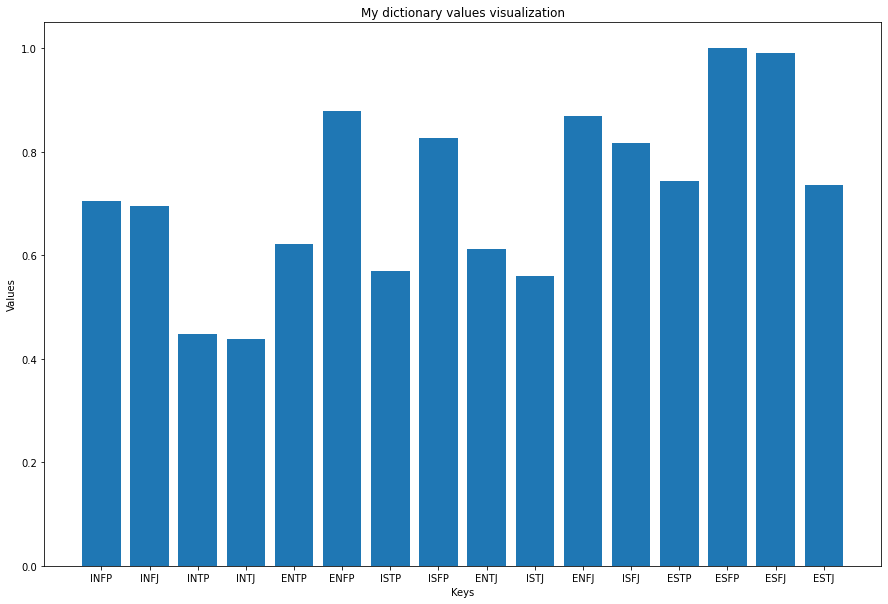

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))

# Sample dictionary
# my_dict = {'a': 10, 'b': 20, 'c': 30, 'd': 40}
max_val = max(res.values())

# Normalize values between 0 and 1
res = {k: v/max_val for k, v in res.items()}
# Extract values and keys
values = res.values()
keys = res.keys()

# Create a bar plot
plt.bar(keys, values)

# Add labels and title
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('My dictionary values visualization')

# Show the plot
plt.show()


## SVC

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
import pickle
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score
from sklearn.calibration import CalibratedClassifierCV


In [ ]:
X = personality_data['posts'] # features
y = personality_data['type']  # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
recreate_model=False
filename = '/content/drive/MyDrive/NLP_PACKAGE/mbti_svm_v2.sav'

In [ ]:
# Check if need to recreate the model
if recreate_model:    
    
    # Creating an instance to vectorizer:
    vectorizer = TfidfVectorizer()
    
    # Training the vectorizer:
    X_train_tfidf = vectorizer.fit_transform(X_train)
    
    # Training the classifier:
    clf = LinearSVC()
    clf.fit(X_train_tfidf, y_train)
    
    # Pipelining the vectorizer and the classifier
    text_clf = Pipeline([('tfidf',TfidfVectorizer()),('clf',LinearSVC())])
    text_clf.fit(X_train, y_train)
    
    # saving the model to disk
    pickle.dump(text_clf, open(filename, 'wb'))

# If there is no need to recreate the model, just open the file from the disk    
else:
    # loading the model from disk
    text_clf = pickle.load(open(filename, 'rb'))

In [ ]:
# Let's say you have a string to classify
# input_string = "I love you babe"

# # Use the trained pipeline to predict the personality type
# predicted_type = text_clf.predict([[input_string]])[0]
# # class_probabilities = text_clf.predict_proba([input_string])[0]
# class_probabilities = text_clf.predict_proba(X_test)
# # Print the predicted personality type
# print(predicted_type)


In [ ]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV

# Load the trained model from disk
filename = '/content/drive/MyDrive/NLP_PACKAGE/mbti_svm_v2.sav'
model = pickle.load(open(filename, 'rb'))

# Example input string
input_string = 'I love to roam and meet new people'

# Process the input string using the vectorizer
vectorizer = model.named_steps['tfidf']
input_tfidf = vectorizer.transform([input_string])

# Predict the personality type
calibrated_clf = model.named_steps['clf']
predicted_proba = calibrated_clf.predict_proba(input_tfidf)
predicted_personality = calibrated_clf.classes_[predicted_proba.argmax()]

print(f'The predicted personality type for "{input_string}" is {predicted_personality}.')
label =['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP']
prob = predicted_proba[0]

res = {}
for i in range(16):
  res[label[i]] = prob[i]


The predicted personality type for "I love to roam and meet new people" is INFP.


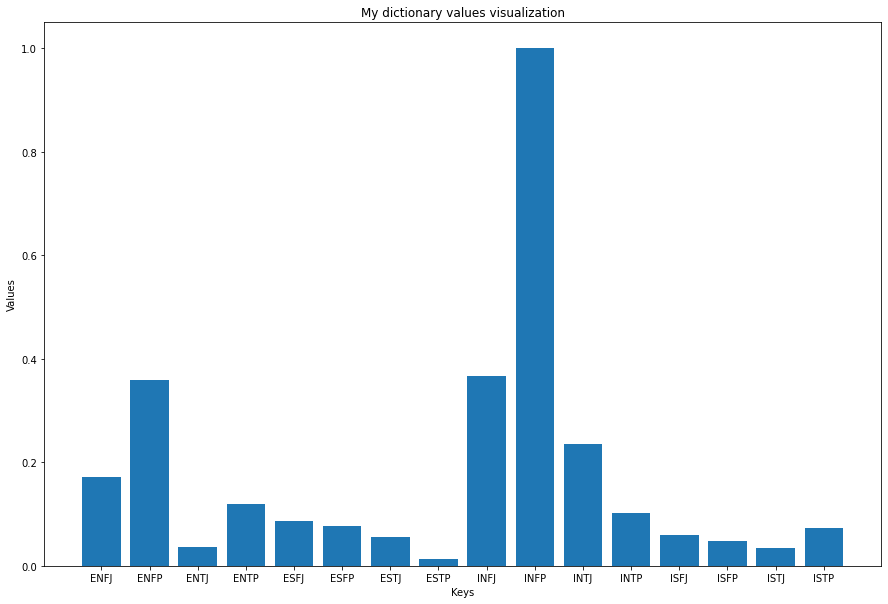

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))

# Sample dictionary
# my_dict = {'a': 10, 'b': 20, 'c': 30, 'd': 40}
max_val = max(res.values())

# Normalize values between 0 and 1
res = {k: v/max_val for k, v in res.items()}
# Extract values and keys
values = res.values()
keys = res.keys()

# Create a bar plot
plt.bar(keys, values)

# Add labels and title
plt.xlabel('Keys')
plt.ylabel('Values')
plt.title('My dictionary values visualization')

# Show the plot
plt.show()

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 19.8 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

# Load the tokenizer and model for the specific NER task
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")

# Create the NER pipeline
nlp = pipeline("ner", model=model, tokenizer=tokenizer)

text = input("Enter your long text: ")

results = nlp(text)

for result in results:
    print(result)


Enter your long text: Hi I am ALagu living in Tiruupuur, but my boss today shouted at me Ramya, for just chilling out
{'entity': 'I-ORG', 'score': 0.67666537, 'index': 4, 'word': 'AL', 'start': 8, 'end': 10}
{'entity': 'I-PER', 'score': 0.7425848, 'index': 5, 'word': '##agu', 'start': 10, 'end': 13}
{'entity': 'I-LOC', 'score': 0.99569905, 'index': 8, 'word': 'T', 'start': 24, 'end': 25}
{'entity': 'I-LOC', 'score': 0.9579995, 'index': 9, 'word': '##ir', 'start': 25, 'end': 27}
{'entity': 'I-LOC', 'score': 0.8226492, 'index': 10, 'word': '##u', 'start': 27, 'end': 28}
{'entity': 'I-LOC', 'score': 0.7625259, 'index': 11, 'word': '##up', 'start': 28, 'end': 30}
{'entity': 'I-LOC', 'score': 0.65837306, 'index': 12, 'word': '##u', 'start': 30, 'end': 31}
{'entity': 'I-LOC', 'score': 0.935152, 'index': 13, 'word': '##ur', 'start': 31, 'end': 33}
{'entity': 'I-PER', 'score': 0.99602157, 'index': 22, 'word': 'Ram', 'start': 67, 'end': 70}
{'entity': 'I-PER', 'score': 0.9948232, 'index': 23, '

In [ ]:
text = input("Enter some text: ")

# perform NER on the text
ner_results = nlp(text)

# print the NER results
for result in ner_results:
    print(f"Word: {result['word']}, Tag: {result['entity']}, Probability: {result['score']}")

Enter some text: Hi I am janani, and you must be Sam right? Well my day was bad...what your boss Ram is here? Oh I thought he was at the backyard sniffing the cat with a bag. Okay I am going to get a cab
Word: j, Tag: I-PER, Probability: 0.6243192553520203
Word: ##ana, Tag: I-PER, Probability: 0.5052528381347656
Word: ##ni, Tag: I-PER, Probability: 0.8133019208908081
Word: Sam, Tag: I-PER, Probability: 0.9908915162086487
Word: Ram, Tag: I-PER, Probability: 0.9936957955360413


In [ ]:
entities = {"I-PER": [], "I-LOC": [], "I-ORG": [], "I-MISC": []}

# iterate through the NER results and add the entities to the dictionary
for result in ner_results:
    if result['entity'] in entities:
        entities[result['entity']].append(result['word'])
    else:
      entities[result['entity']] = [result['word']]

# print the entities and their types
for entity_type, entity_list in entities.items():
    if len(entity_list) > 0:
        print(f"{entity_type}: {', '.join(entity_list)}")

I-PER: j, ##ana, ##ni, Sam, Ram


In [ ]:
entities

{'I-PER': ['j', '##ana', '##ni', 'Sam', 'Ram'],
 'I-LOC': [],
 'I-ORG': [],
 'I-MISC': []}

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

nlp = pipeline("ner", model=model, tokenizer=tokenizer)
example = "Hi I am janani, and you must be Sam right? Well my day was bad...what your boss Ram is here? Oh I thought he was at the backyard sniffing the cat with a bag. Okay I am going to get a cab"

ner_results = nlp(example)
print(ner_results)


[{'entity': 'B-PER', 'score': 0.9990139, 'index': 4, 'word': 'Wolfgang', 'start': 11, 'end': 19}, {'entity': 'B-LOC', 'score': 0.999645, 'index': 9, 'word': 'Berlin', 'start': 34, 'end': 40}]


In [ ]:
example = "The school in London Killer went to shopping mall with John"

ner_results = nlp(example)
print(ner_results)

## BERT

In [ ]:
!pip install transformers
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 111.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from transformers import TFBertModel, BertTokenizer
seed_value = 29
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
np.set_printoptions(precision=2)
import tensorflow as tf
tf.random.set_seed(seed_value)
import tensorflow_addons as tfa
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.callbacks import ModelCheckpoint
import re
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
N_AXIS = 4
MAX_SEQ_LEN = 128
BERT_NAME = 'bert-base-uncased'
'''
EMOTIONAL AXES:
Introversion (I) – Extroversion (E)
Intuition (N) – Sensing (S)
Thinking (T) – Feeling (F)
Judging (J) – Perceiving (P)
'''
axes = ["I-E","N-S","T-F","J-P"]
classes = {"I":0, "E":1, # axis 1
           "N":0,"S":1, # axis 2
           "T":0, "F":1, # axis 3
           "J":0,"P":1} # axis 4

In [ ]:
def text_preprocessing(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text.encode('ascii', 'ignore').decode('ascii')
    if text.startswith("'"):
        text = text[1:-1]
    return text

In [ ]:
train_n=6624
val_n=1024
test_n=1024
data = pd.read_csv("/content/drive/MyDrive/NLP_PACKAGE/cleaned_data.csv")
data = data.sample(frac=1)
labels = []
print(data)
for personality in data["type"]:
    pers_vect = []
    for p in personality:
        pers_vect.append(classes[p])
    labels.append(pers_vect)
# sentences = data["posts"].apply(str).apply(lambda x: text_preprocessing(x))
sentences = data["clean_posts"]
labels = np.array(labels, dtype="float32")
train_sentences = sentences[:train_n]
y_train = labels[:train_n]
val_sentences = sentences[train_n:train_n+val_n]
y_val = labels[train_n:train_n+val_n]
test_sentences = sentences[train_n+val_n:train_n+val_n+test_n]
y_test = labels[train_n+val_n:train_n+val_n+test_n]

      Unnamed: 0  type  is_Extrovert  is_Sensing  is_Thinking  is_Judging  \
4558        3696  ISTP             0           1            1           0   
2401        7487  INTP             0           0            1           0   
6952        7566  ISFP             0           1            0           0   
1174         803  INFJ             0           0            0           1   
5021         847  INTP             0           0            1           0   
...          ...   ...           ...         ...          ...         ...   
920         5360  ISTJ             0           1            1           1   
864         4416  ENTP             1           0            1           0   
808         3790  ENFP             1           0            0           0   
6380        8481  ENTP             1           0            1           0   
8149        7873  INTP             0           0            1           0   

                                                  posts  \
4558  'The marti

In [ ]:
def prepare_bert_input(sentences, seq_len, bert_name):
    tokenizer = BertTokenizer.from_pretrained(bert_name)
    encodings = tokenizer(sentences.tolist(), truncation=True, padding='max_length',
                                max_length=seq_len)
    input = [np.array(encodings["input_ids"]), np.array(encodings["token_type_ids"]),
               np.array(encodings["attention_mask"])]
    return input

In [ ]:
X_train = prepare_bert_input(train_sentences, MAX_SEQ_LEN, BERT_NAME)
X_val = prepare_bert_input(val_sentences, MAX_SEQ_LEN, BERT_NAME)
X_test = prepare_bert_input(test_sentences, MAX_SEQ_LEN, BERT_NAME)

In [ ]:
input_ids = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='input_ids')
input_type = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='token_type_ids')
input_mask = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name='attention_mask')
inputs = [input_ids, input_type, input_mask]
bert = TFBertModel.from_pretrained(BERT_NAME)
bert_outputs = bert(inputs)
last_hidden_states = bert_outputs.last_hidden_state
avg = layers.GlobalAveragePooling1D()(last_hidden_states)
output = layers.Dense(N_AXIS, activation="sigmoid")(avg)
model = keras.Model(inputs=inputs, outputs=output)
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'token_type_ids[0][0]',     

In [ ]:
max_epochs = 7
batch_size = 32
opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
loss = keras.losses.BinaryCrossentropy()
best_weights_file = "/content/drive/MyDrive/NLP_PACKAGE/berto_weights.h5"
auc = keras.metrics.AUC(multi_label=True, curve="ROC")
m_ckpt = ModelCheckpoint(best_weights_file, monitor='val_'+auc.name, mode='max', verbose=2,
                          save_weights_only=True, save_best_only=True)
model.compile(loss=loss, optimizer=opt, metrics=[auc, keras.metrics.BinaryAccuracy()])
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    batch_size=batch_size,
    callbacks=[m_ckpt],
    verbose=2
)

Epoch 1/7



Epoch 1: val_auc_1 improved from -inf to 0.64157, saving model to /content/drive/MyDrive/NLP_PACKAGE/berto_weights.h5
207/207 - 222s - loss: 0.5670 - auc_1: 0.5578 - binary_accuracy: 0.7061 - val_loss: 0.5529 - val_auc_1: 0.6416 - val_binary_accuracy: 0.7227 - 222s/epoch - 1s/step
Epoch 2/7

Epoch 2: val_auc_1 improved from 0.64157 to 0.65123, saving model to /content/drive/MyDrive/NLP_PACKAGE/berto_weights.h5
207/207 - 188s - loss: 0.5454 - auc_1: 0.6398 - binary_accuracy: 0.7252 - val_loss: 0.5551 - val_auc_1: 0.6512 - val_binary_accuracy: 0.7227 - 188s/epoch - 910ms/step
Epoch 3/7

Epoch 3: val_auc_1 improved from 0.65123 to 0.65647, saving model to /content/drive/MyDrive/NLP_PACKAGE/berto_weights.h5
207/207 - 188s - loss: 0.5189 - auc_1: 0.6998 - binary_accuracy: 0.7431 - val_loss: 0.5635 - val_auc_1: 0.6565 - val_binary_accuracy: 0.7134 - 188s/epoch - 909ms/step
Epoch 4/7

Epoch 4: val_auc_1 did not improve from 0.65647
207/207 - 184s - loss: 0.4740 - auc_1: 0.7676 - binary_accur

In [ ]:
loss = keras.losses.BinaryCrossentropy()
best_weights_file = "/content/drive/MyDrive/NLP_PACKAGE/berto_weights.h5"
model.load_weights(best_weights_file)
opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
model.compile(loss=loss, optimizer=opt, metrics=[keras.metrics.AUC(multi_label=True, curve="ROC"),
                                                  keras.metrics.BinaryAccuracy()])
predictions = model.predict(X_test)
model.evaluate(X_test, y_test, batch_size=32)

30/30 [==============================] - 13s 274ms/step - loss: 0.5602 - auc_2: 0.6560 - binary_accuracy: 0.7176


[0.5601601004600525, 0.6560217142105103, 0.7175531983375549]

In [ ]:
s1 = "I dont like to talk "
sentences = np.asarray([s1])
enc_sentences = prepare_bert_input(sentences, MAX_SEQ_LEN, BERT_NAME)
predictions = model.predict(enc_sentences)
for sentence, pred in zip(sentences, predictions):
    pred_axis = []
    mask = (pred > 0.5).astype(bool)
    for i in range(len(mask)):
        if mask[i]:
            pred_axis.append(axes[i][2])
        else:
            pred_axis.append(axes[i][0])
    print('-- comment: '+sentence.replace("\n", "").strip() +
          '\n-- personality: '+str(pred_axis) +
          '\n-- scores:'+str(pred))

1/1 [==============================] - 0s 75ms/step
-- comment: I dont like to talk
-- personality: ['I', 'N', 'F', 'P']
-- scores:[0.29 0.41 0.68 0.81]
